#### The United States Social Security Administration (SSA) has made available datat on the frequency of baby namse from 1880 through the 2010. 

In [1]:
"""
There are many things we might want to do with the data set.
1. Visualize the proportion of babies given a particular name over time.
2. Determine the relative rank of a name.
3. Determine the most popular names in each year or the names with largest increases or decreases.
4. Analyze trends in names: vowels, consonants, length, overall diversity, changes in spelling, first and last letters.
5. Analyze external sources of trends: biblical names, celebrities, demograohic changes
"""

'\nThere are many things we might want to do with the data set.\n1. Visualize the proportion of babies given a particular name over time.\n2. Determine the relative rank of a name.\n3. Determine the most popular names in each year or the names with largest increases or decreases.\n4. Analyze trends in names: vowels, consonants, length, overall diversity, changes in spelling, first and last letters.\n5. Analyze external sources of trends: biblical names, celebrities, demograohic changes\n'

In [2]:
import numpy as np
import pandas as pd

In [3]:
name1880 = pd.read_csv('names/yob1880.txt', names=['name', 'sex', 'births'])

In [4]:
name1880[:10]

,name,sex,births
0,Mary,F,7065
1,Anna,F,2604
2,Emma,F,2003
3,Elizabeth,F,1939
4,Minnie,F,1746
5,Margaret,F,1578
6,Ida,F,1472
7,Alice,F,1414
8,Bertha,F,1320
9,Sarah,F,1288


In [6]:
# These files only conatin names with atleast 5 occurrences in each year
# For simplicity's sake we can use the sum of the births column by sex as the total number of births in that year
name1880.groupby('sex').births.sum()

sex
F     90994
M    110490
Name: births, dtype: int64

In [7]:
# Since the dataset is split into files by year, one of the first things to do is to assemble all of the data 
# into single Dataframe and further to add a year field.

# 2010 is the last avilable right now
years = range(1880, 2011)

pieces = []
columns = ['name', 'sex', 'births']

for year in years:
    path = 'names/yob%d.txt' %year
    frame = pd.read_csv(path, names=columns)
    
    frame['year'] = year
    pieces.append(frame)

In [9]:
# Concatenate everything into a single DataFrame
names = pd.concat(pieces, ignore_index=True)

# concat glues the DataFrame objects together row-wise by default.
# you have to pass ignore_index=True because we're intrested in preserving the original row numbers returned from read_csv

In [10]:
total_births =  names.pivot_table('births', index='year', columns='sex', aggfunc=sum)

In [11]:
total_births.tail()

sex,F,M
year,,
2006,1899824,2053753
2007,1921053,2073784
2008,1889069,2038194
2009,1835062,1981481
2010,1775345,1916476


In [ ]:
total_births.plot(figsize=(12, 10), title='Fig. Total births by sex and year')

In [ ]:
# Now let's insert a column with the fraction of babies given each names relative to the total number of births.
# A porp value of 0.02 would indicate that 2 out of every 100 babies was given a particular name.
# Thus, we group the data by the year and sex, then add the new column to each group

def add_prop(group):
    # Integer division floors
    births = group.births.astype(float)
    
    group['prop'] = births / births.sum()
    return group

names = names.groupby(['year', 'sex']).apply(add_prop)

In [13]:
names[:10]

,name,sex,births,year,prop
0,Mary,F,7065,1880,0.077642
1,Anna,F,2604,1880,0.028617
2,Emma,F,2003,1880,0.022012
3,Elizabeth,F,1939,1880,0.021309
4,Minnie,F,1746,1880,0.019188
5,Margaret,F,1578,1880,0.017342
6,Ida,F,1472,1880,0.016177
7,Alice,F,1414,1880,0.015539
8,Bertha,F,1320,1880,0.014506
9,Sarah,F,1288,1880,0.014155


In [16]:
# When performing a group operation like this, it's often valuable to do a sanity check
# like verifying that the prop columns sums to 1 within all the groups. 
# Since this is a floating point data, use np.allclose to check that the group sums are sufficiently close to (but perhaps not exaclty equal to 1)

np.allclose(names.groupby(['year', 'sex']).prop.sum(), 1)

True

In [19]:
# Extract subset of the data to facilitate further analys:
# the top 1000 names for each sex/year combination

def get_top1000(group):
    return group.sort_values(by='births', ascending=False)[:1000]

grouped = names.groupby(['year', 'sex'])
top1000 = grouped.apply(get_top1000)

In [22]:
top1000[:10]

name sex  births  year      prop
year sex                                         
1880 F   0       Mary   F    7065  1880  0.077642
         1       Anna   F    2604  1880  0.028617
         2       Emma   F    2003  1880  0.022012
         3  Elizabeth   F    1939  1880  0.021309
         4     Minnie   F    1746  1880  0.019188
         5   Margaret   F    1578  1880  0.017342
         6        Ida   F    1472  1880  0.016177
         7      Alice   F    1414  1880  0.015539
         8     Bertha   F    1320  1880  0.014506
         9      Sarah   F    1288  1880  0.014155

## Analyzing Naming Trends

In [23]:
# Spiltting the top 1000 names into boy and girl
boys = top1000[top1000.sex == 'M']
girls = top1000[top1000.sex == 'F']

In [26]:
# Simple time series, like the number of John or Marys for each year can be plotted but require a bit of munging to be a bit more useful.

total_births = top1000.pivot_table('births', index='year', columns='name', aggfunc=sum)

/home/parag/anaconda3/lib/python3.6/site-packages/pandas/core/reshape/pivot.py:81: FutureWarning: 'year' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  grouped = data.groupby(keys)


In [28]:
subset = total_births[['John', 'Harry', 'Mary', 'Marilyn']]

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f6f03029438>,
      dtype=object)

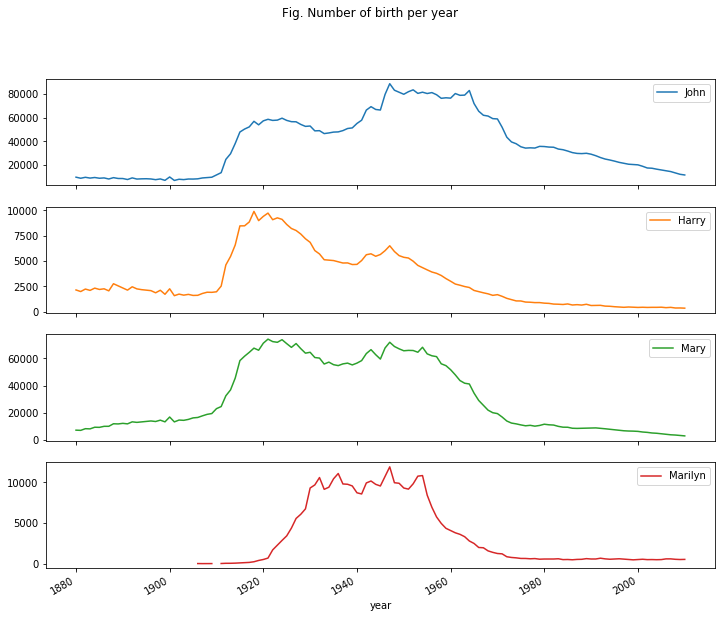

In [31]:
subset.plot(subplots=True, figsize=(12, 10), grid=False, title="Fig. Number of birth per year")

#### Measuring the increase in naming diversity

In [34]:
# One explatanation for the decrease in plots above is that fewer parent are choosing common names for their children.
# This hypothesis can be explored and confirmed in the data.
# One measure is the proportion of the births represented by the top 1000 most popular names, which is aggregated and plot by year and sex.

table = top1000.pivot_table('prop', index='year', columns='sex', aggfunc=sum)

/home/parag/anaconda3/lib/python3.6/site-packages/pandas/core/reshape/pivot.py:81: FutureWarning: 'year' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  grouped = data.groupby(keys)
/home/parag/anaconda3/lib/python3.6/site-packages/pandas/core/reshape/pivot.py:81: FutureWarning: 'sex' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  grouped = data.groupby(keys)


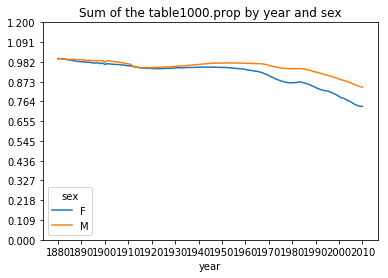

In [36]:
# Fig. Proportion of births represented in top 1000 names by sex
table.plot(title='Sum of the table1000.prop by year and sex', yticks=np.linspace(0, 1.2, 12), xticks=range(1880, 2020, 10))

In [37]:
# There appears to be increasing name diversity (decreasing total propotion in the top 1000)
# Another intreseting metrics is the number of distinct names, taken in order of popularity from highest to lowest, in the top 50% of births.
# This number is a bit more triciky to compute. Let's consider just the boys names from 2010

df = boys[boys.year == 2010]

In [38]:
# After sorting prop in descending order we want to know how many of the most popular names it takes to reach 50%.
# We can write write a loop to do this, but vectorized NumPy way is a bit more clever.
# Taking the cumulative sum, cumsum, of prop then caling the method searchsorted return the position 
# in the cumulative sum at which 0.5 would need to be inserted to keep it sorted order.

prop_cumsum = df.sort_values(by='prop', ascending=False).prop.cumsum()

In [39]:
prop_cumsum[:10]

year  sex         
2010  M    1677854    0.011546
           1677855    0.020939
           1677856    0.029992
           1677857    0.038956
           1677858    0.047853
           1677859    0.056596
           1677860    0.065180
           1677861    0.073447
           1677862    0.081554
           1677863    0.089638
Name: prop, dtype: float64

In [40]:
prop_cumsum.searchsorted(0.5)

array([116])

In [42]:
# Since arrays are zero-indexed, adding 1 to this reuslt gives result of 117
# By contrast, in 1900 this number was much smaller

df = boys[boys.year == 1900]

In [44]:
in1900 = df.sort_values(by='prop', ascending=False).prop.cumsum()

In [45]:
in1900.searchsorted(0.5) + 1

array([25])

In [127]:
# It should now be fairly straightforward to apply this operations to each year/sex combination;
# groupby those fields and apply a function returning the count for each group

def get_quantile_count(group, q=0.5):
    group = group.sort_values(by='prop', ascending=False)
    return group.prop.cumsum().searchsorted(q) + 1

diversity = top1000.groupby(['year', 'sex']).apply(get_quantile_count)

/home/parag/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: 'year' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  
/home/parag/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: 'sex' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  


In [128]:
diversity = diversity.unstack('sex')
diversity.head()

sex,F,M
year,,
1880,[38],[14]
1881,[38],[14]
1882,[38],[15]
1883,[39],[15]
1884,[39],[16]


In [129]:
idx = 1880
for val in diversity.F:
    diversity['F'][idx] = val[0]
    idx += 1
idx = 1880
for val in diversity.M:
    diversity['M'][idx] = val[0]
    idx += 1
    

In [130]:
diversity.head()

sex,F,M
year,,
1880,38,14
1881,38,14
1882,38,15
1883,39,15
1884,39,16


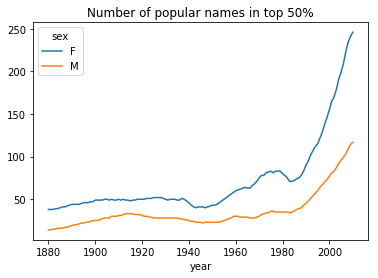

In [131]:
# The resulting DataFrame diversity now has two series, one for each sex, indexed by year.

# Plot of diversity metrics by year
diversity.plot(title='Number of popular names in top 50%')

## The "Last Letter" Revolution

In [132]:
# In 2007, a baby names researcher Laura Wattenberg pointed out on her website that the distribution 
# of boy names by final letter has changed significatnly over the last 100 years

# Aggerate all of the births in the full data set by year, sex and final letter
# extract last letter from column
get_last_letter = lambda x: x[-1]
last_letters = names.name.map(get_last_letter)
last_letters.name = 'last_letter'

In [133]:
table = names.pivot_table('births', index=last_letters, columns=['sex', 'year'], aggfunc=sum)

In [134]:
# Select out three respresntative years spanning the history and print the first rows
subtable = table.reindex(columns=[1910, 1960, 2010], level='year')

In [135]:
subtable.head()

sex                 F                            M                    
year             1910      1960      2010     1910      1960      2010
last_letter                                                           
a            108399.0  691261.0  676865.0    977.0    5212.0   28868.0
b                 NaN     694.0     455.0    411.0    3912.0   39276.0
c                 5.0      49.0     956.0    482.0   15454.0   23348.0
d              6751.0    3731.0    2642.0  22113.0  262116.0   44828.0
e            133601.0  435030.0  316764.0  28665.0  178768.0  130253.0

In [136]:
# Normalize the table by total births to compute a new table containing proportion of the total births for each sex ending in each letter
subtable.sum()

sex  year
F    1910     396505.0
     1960    2022010.0
     2010    1775345.0
M    1910     194212.0
     1960    2132155.0
     2010    1916476.0
dtype: float64

In [137]:
letter_prop = subtable / subtable.sum().astype(float)

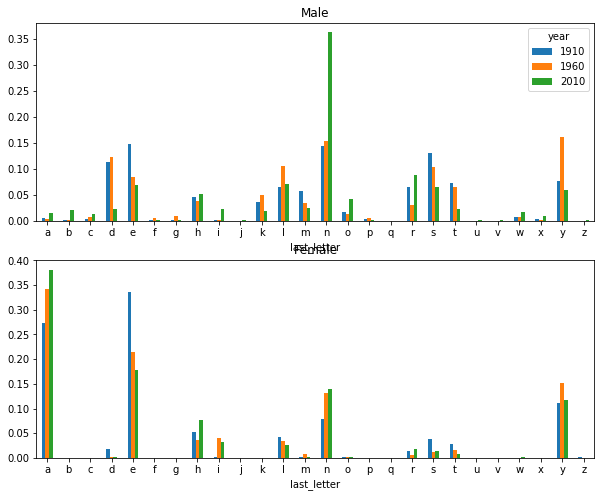

In [139]:
# We the letter proportion in hand, we can make bar plots for each sex broken down by year.
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, figsize=(10, 8))
letter_prop['M'].plot(kind='bar', rot=0, ax=axes[0], title='Male')
letter_prop['F'].plot(kind='bar', rot=0, ax=axes[1], title='Female', legend=False)

In [141]:
# AS we can see names ending in "n" have experienced significant growth since the 1960s
# Going back to full table created above, normalize by year and sex and select a subset of letters for the boy names,
# finally tansposing to make each column a time series

letter_prop = table / table.sum().astype('float')

In [142]:
dny_ts = letter_prop.loc[['d', 'n', 'y'], 'M'].T

In [143]:
dny_ts.head()

last_letter,d,n,y
year,,,
1880,0.083057,0.153217,0.075763
1881,0.083242,0.153212,0.077455
1882,0.085332,0.149561,0.077538
1883,0.084053,0.151656,0.079149
1884,0.086122,0.149927,0.080408


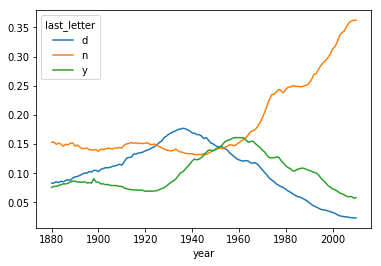

In [145]:
# With this DataFrame of time series in hand, we can make a plot

# Proportion of boys born with names ending in d/n/yover time
dny_ts.plot()

#### Boy names that became girl names (vice versa)

In [146]:
# Another fun trend is looking boys name that were more popular with one sex earlier in the sample
# but have "changed sexes" in the present.
# One example is the name Lesly or Leslie
# Going back to top1000 dataset, compute a list of names occuring in the dataset starting with 'lesl'

all_names = top1000.name.unique()

In [147]:
mask = np.array(['lesl' in x.lower() for x in all_names])

In [148]:
lesley_like = all_names[mask]

In [149]:
lesley_like

array(['Leslie', 'Lesley', 'Leslee', 'Lesli', 'Lesly'], dtype=object)

In [150]:
# From there, we can filter down to just those names and sum births grouped by name to see relative frequencies

filtered = top1000[top1000.name.isin(lesley_like)]

In [151]:
filtered.groupby('name').births.sum()

name
Leslee       993
Lesley     35033
Lesli        929
Leslie    370568
Lesly      10072
Name: births, dtype: int64

In [152]:
# Next, let's aggregate by sex and year and normalize within year

table = filtered.pivot_table('births', index='year', columns='sex', aggfunc=sum)

/home/parag/anaconda3/lib/python3.6/site-packages/pandas/core/reshape/pivot.py:81: FutureWarning: 'year' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  grouped = data.groupby(keys)
/home/parag/anaconda3/lib/python3.6/site-packages/pandas/core/reshape/pivot.py:81: FutureWarning: 'sex' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  grouped = data.groupby(keys)


In [153]:
table = table.div(table.sum(1), axis=0)

In [154]:
table.tail()

sex,F,M
year,,
2006,1.0,NaN
2007,1.0,NaN
2008,1.0,NaN
2009,1.0,NaN
2010,1.0,NaN


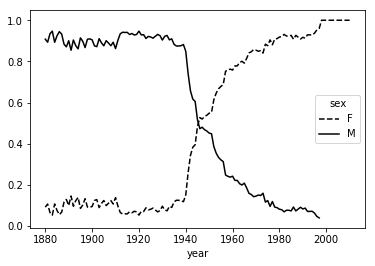

In [157]:
# Lastly, it's now easy to make a plot of the breakdown by sex over time

# Proportion of male/female Lesley-like names over time
table.plot(style={'M': 'k-', 'F': 'k--'})

### The focus of this book is on tools as opposed to presenting more sophisticated analytical methods. Mastering the techniques in this book will enable us to implement our own analyses (assuming you know what you want to do!) in short order.